In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
import sys
import platform

if platform.system() == "Darwin":
    neuropy_path = Path('/Users/nkinsky/Documents/UM/GitHub/NeuroPy')
    eraser_path = Path('/Users/nkinsky/Documents/BU/GitHub/Eraser')
elif platform.system() == "Linux":
    neuropy_path = Path('/data/GitHub/NeuroPy')
    eraser_path = Path('/data/GitHub/Eraser')
sys.path.append(str(neuropy_path))
sys.path.append(str(eraser_path))
%load_ext autoreload
%autoreload 2

from neuropy.utils.ccg import correlograms
from neuropy.utils.mathutil import contiguous_regions
from neuropy.io.openephysio import get_dat_timestamps, get_lfp_timestamps, create_sync_df, recording_events_to_combined_time
from neuropy.plotting import Fig
from neuropy.io.binarysignalio import BinarysignalIO
from neuropy.plotting.signals import plot_signal_traces
from neuropy.utils.signal_process import filter_sig

# Eraser github imports
from Ephys.ephys import *
# from plotting import Fig, pretty_plot, FigMirror

In [2]:
# Set Data and Figure Directories
# Needs to be set for each PC
fig_save_dir = Path('/data3/Anisomycin/Recording_Rats/Creampuff')
working_dir = Path('/data3/Anisomycin/Recording_Rats/Creampuff')

In [3]:
FigS7 = Fig(4, 5, num="Figure S7_2", size=(7, 3), fontsize=6)
print(FigS7.fig.get_size_inches())

[7. 3.]


<Figure size 700x300 with 0 Axes>

In [4]:
saline1_folder = '2024_07_15_Saline1'
ani_folder = '2024_07_17_Anisomycin'
saline2_folder = '2024_07_18_Saline2'

folder_list = [saline1_folder, ani_folder, saline2_folder]
unit_type = ['single', 'single', 'single']
session = ['saline1', 'ANI', 'saline2']

In [5]:
ani_timestamps = get_dat_timestamps(working_dir / ani_folder)
# ani_timestamps = get_lfp_timestamps(working_dir / ani_folder)

OE version >= 0.6 detected, check timestamps. Could be off by factor = Sampling Rate
start time = 2024-07-17 10:12:28-04:00
start time = 2024-07-17 10:18:16-04:00
start time = 2024-07-17 10:26:56-04:00
start time = 2024-07-17 10:34:03-04:00
start time = 2024-07-17 10:42:12-04:00
start time = 2024-07-17 12:21:10-04:00
start time = 2024-07-17 12:56:44-04:00
start time = 2024-07-17 14:12:18-04:00


### Sanity check plot - should be a 1/1 line approximately

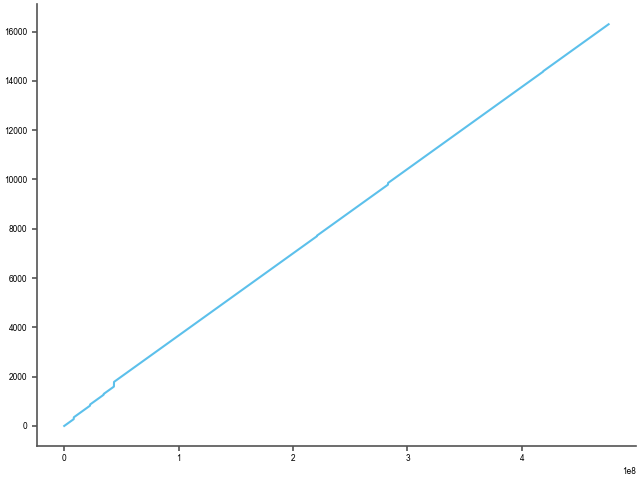

In [6]:
%matplotlib widget
_, ax = plt.subplots()
dt = ani_timestamps - ani_timestamps.iloc[0]
ax.plot(dt.reset_index()[0].dt.total_seconds())

In [7]:
ani_epochs = load_events_csv(ani_folder, ani_timestamps.iloc[0], working_dir=working_dir)
ani_epochs["start"] = ani_epochs["start"].dt.tz_localize("America/Detroit")
ani_epochs["stop"] = ani_epochs["stop"].dt.tz_localize("America/Detroit")
ani_epochs

,start,stop,label
0,2024-07-17 10:12:29-04:00,2024-07-17 10:39:00-04:00,pre
1,2024-07-17 10:40:30-04:00,2024-07-17 10:41:00-04:00,ANI
2,2024-07-17 10:42:13-04:00,2024-07-17 12:20:00-04:00,post
3,2024-07-17 12:21:11-04:00,2024-07-17 12:55:00-04:00,track1
4,2024-07-17 12:56:45-04:00,2024-07-17 14:11:30-04:00,post2
5,2024-07-17 14:12:19-04:00,2024-07-17 14:22:00-04:00,track2


In [8]:
corr_by_epoch_ani, time_bins_ani, epochs_used_ani = calc_ccg_by_epoch(ani_folder, timestamps=ani_timestamps, 
                                                                      working_dir=working_dir)

Calculating CCGs for epoch pre
Calculating CCGs for epoch ANI
Calculating CCGs for epoch post
Calculating CCGs for epoch track1
Calculating CCGs for epoch post2
Calculating CCGs for epoch track2


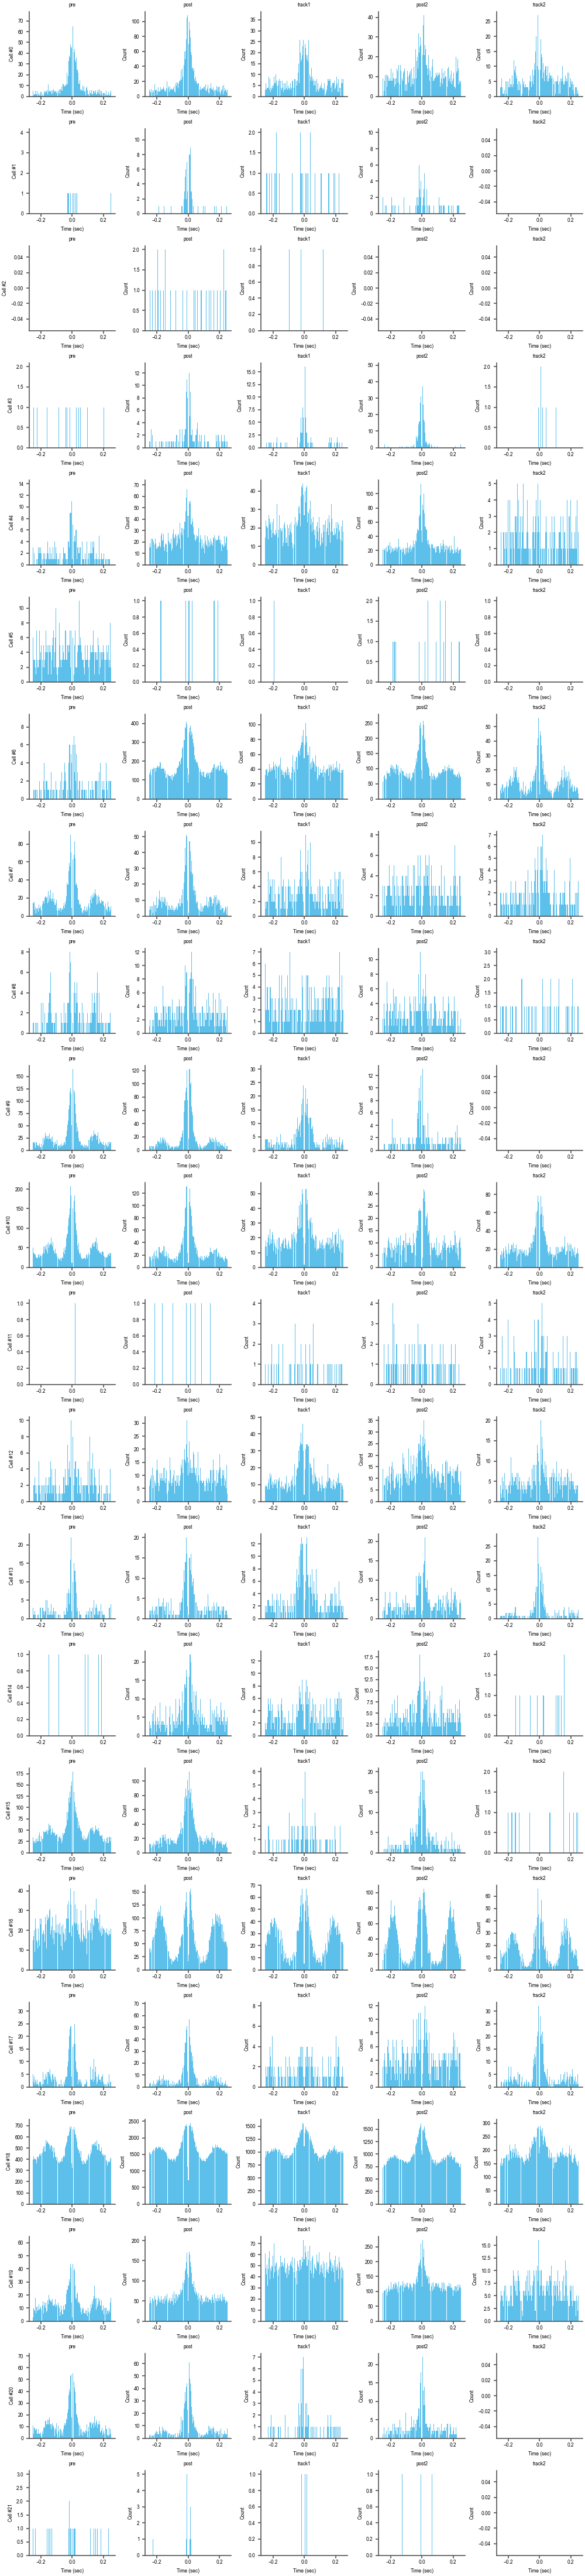

In [9]:
# Plot all cells for references
ncells = corr_by_epoch_ani.shape[1]
fig, ax = plt.subplots(ncells, 5, figsize=(10, ncells*2))
for idn, a in enumerate(ax):
    # fig, ax = plt.subplots(1, 5, figsize=(8, 2))
    plot_ccg_by_epoch(corr_by_epoch_ani[:, idn, idn, :].reshape((corr_by_epoch_ani.shape[0], 1, 1, corr_by_epoch_ani.shape[3])), 
                  time_bins_ani, epochs_used_ani, 'ANI combined', ax=a[None, :])
    a[0].set_ylabel(f"Cell #{idn}")

In [10]:
# Save
fig.savefig(Path('/home/nkinsky/Dropbox (University of Michigan)/Eraser/Figures/Figure Dumps') / "ACGs_Rat2_ANI_all_cells.pdf")

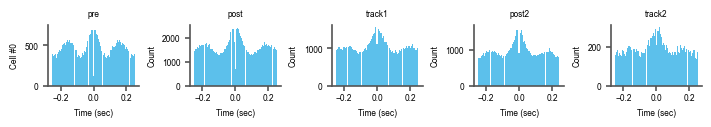

In [11]:
# Plot ACGs
ax_saline2 = []
for i in range(5):
    ax_saline2.append(FigS7.subplot(FigS7.gs[0, i]))
ax_saline2 = np.array(ax_saline2)[None, :]
plot_ccg_by_epoch(corr_by_epoch_ani[:, 18, 18, :].reshape((corr_by_epoch_ani.shape[0], 1, 1, corr_by_epoch_ani.shape[3])), 
                  time_bins_ani, epochs_used_ani, 'ANI combined', ax=ax_saline2)

FigS7.fig

### Import eeg file and get raw theta and SWR traces

In [12]:
# Find EEG file and get Theta/SWR signals
sorted((working_dir / ani_folder).glob("*.eeg"))[0]
ani_signal = BinarysignalIO(sorted((working_dir / ani_folder).glob("*.eeg"))[0], n_channels=35, sampling_rate=1250).get_signal()
print(ani_signal)

In [13]:
sync_df = create_sync_df(working_dir / ani_folder)

OE version >= 0.6 detected, check timestamps. Could be off by factor = Sampling Rate
start time = 2024-07-17 10:12:28-04:00
start time = 2024-07-17 10:18:16-04:00
start time = 2024-07-17 10:26:56-04:00
start time = 2024-07-17 10:34:03-04:00
start time = 2024-07-17 10:42:12-04:00
start time = 2024-07-17 12:21:10-04:00
start time = 2024-07-17 12:56:44-04:00
start time = 2024-07-17 14:12:18-04:00


In [14]:
event_starts = recording_events_to_combined_time(ani_epochs, sync_df, event_ts_key="start")
event_stops = recording_events_to_combined_time(ani_epochs, sync_df, event_ts_key="stop")
ani_epochs.loc[[0, 2, 3, 4, 5], ["eeg_start", "eeg_stop"]] = np.vstack((event_starts, event_stops)).T
ani_epochs

Event(s) # [2] occurs in between recordings and has(have) been left out
Event(s) # [2] occurs in between recordings and has(have) been left out


,start,stop,label,eeg_start,eeg_stop
0,2024-07-17 10:12:29-04:00,2024-07-17 10:39:00-04:00,pre,1.0000,1443.1720
1,2024-07-17 10:40:30-04:00,2024-07-17 10:41:00-04:00,ANI,NaN,NaN
2,2024-07-17 10:42:13-04:00,2024-07-17 12:20:00-04:00,post,1448.2560,7315.2560
3,2024-07-17 12:21:11-04:00,2024-07-17 12:55:00-04:00,track1,7363.9808,9392.9808
4,2024-07-17 12:56:45-04:00,2024-07-17 14:11:30-04:00,post2,9432.1536,13917.1536
5,2024-07-17 14:12:19-04:00,2024-07-17 14:22:00-04:00,track2,13951.4320,14532.4320


### Plot theta traces

(-2.3753182241539896, 1.9065197143744181)

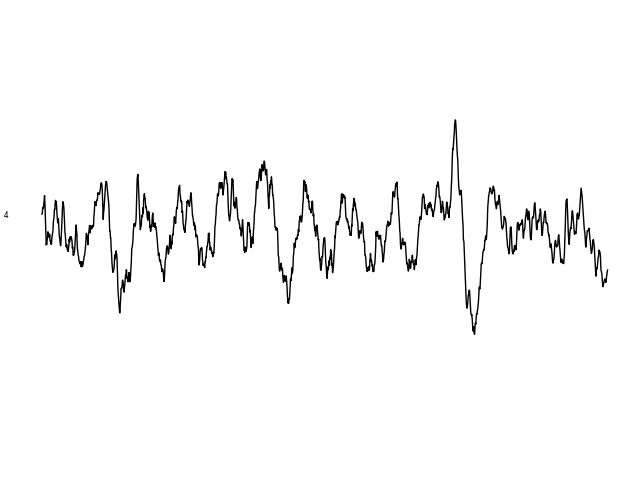

In [15]:
# Make sure it is working well by plotting
# pre_theta = get_epoch_signal(saline2_signal, 'Pre', saline2_epochs, channel_indx=4)
ax = plot_signal_traces(ani_signal.time_slice(t_start=20.5, t_stop=22.4, channel_id=4))
ax.set_ylim(np.array(ax.get_ylim())*2)

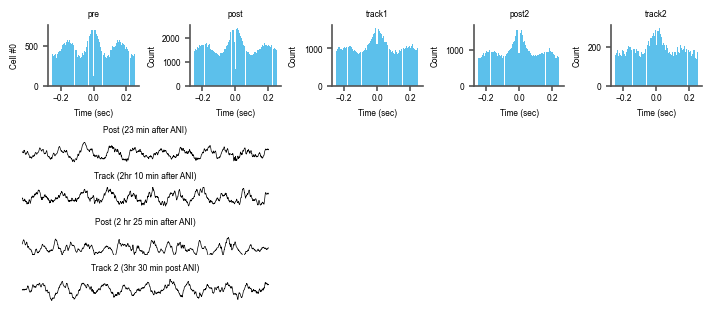

In [16]:
# Set up axes
ax_theta = FigS7.subplot2grid(FigS7.gs[1:, 0:2], grid=(4, 1), return_axes=True)

# Post
plot_signal_traces(ani_signal.time_slice(t_start=(47*60 + 19.8), t_stop=(47*60 + 21.6), channel_id=4), ax=ax_theta[0], lw=0.5)
ax_theta[0].set_title('Post (23 min after ANI)')

# Track1
plot_signal_traces(ani_signal.time_slice(t_start=(156*60 + 18.2), t_stop=(156*60 + 20.1), channel_id=4), ax=ax_theta[1], lw=0.5)
ax_theta[1].set_title('Track (2hr 10 min after ANI)')
ax_theta[1].sharey(ax_theta[0])

# Post 2
plot_signal_traces(ani_signal.time_slice(t_start=(171*60 + 23.8), t_stop=(171*60 + 26.3), channel_id=4), ax=ax_theta[2], lw=0.5)
ax_theta[2].set_title('Post (2 hr 25 min after ANI)')
ax_theta[2].sharey(ax_theta[0])

ax_theta[2].set_ylim(np.array(ax_theta[2].get_ylim())*1.6)

# Track 2
plot_signal_traces(ani_signal.time_slice(t_start=(233*60 + 26.4), t_stop=(233*60 + 28.3), channel_id=4), ax=ax_theta[3], lw=0.5)
ax_theta[3].set_title('Track 2 (3hr 30 min post ANI)')
ax_theta[3].sharey(ax_theta[0])


ax_theta[0].set_ylim((-1, 1))
[sns.despine(ax=a, left=True, bottom=True) for a in ax_theta];
[a.set_yticks([]) for a in ax_theta];
[a.set_xticks([]) for a in ax_theta];
FigS7.fig


### Import neurons

In [17]:
from neuropy.core.session import ProcessData

sess = ProcessData(working_dir / ani_folder)
print(sess.recinfo)

filename: /data3/Anisomycin/Recording_Rats/Creampuff/2024_07_17_Anisomycin/Creampuff_anisomycin.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [18]:
from neuropy.io.phyio import PhyIO
from neuropy.core.neurons import Neurons
phy_dir = sorted(sess.basepath.glob("**/params.py"))[0].parent
sess.phy = PhyIO(dirname=phy_dir)

sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, neuron_ids=sess.phy.neuron_ids,
                       neuron_type=sess.phy.cluster_info["group"], waveforms=sess.phy.waveforms, 
                       waveforms_amplitude=sess.phy.waveforms_amplitude, sampling_rate=sess.recinfo.dat_sampling_rate,
                       peak_channels=sess.phy.peak_channels, shank_ids=sess.phy.shank_ids)

# 
# for sh in np.unique(sess.neurons.shank_ids.astype(int)):
#     sess.recinfo.write_neurons(sess.neurons.neuron_slice(np.where(sess.neurons.shank_ids == sh)[0]), suffix_num=sh)

id column does not exist in cluster_info.tsv. Using cluster_id column instead.


### Get Spikes/Probe Group, Not Necessary after running once

In [19]:
from neuropy.analyses.spkepochs import detect_pbe_epochs
bin_size=0.01
thresh = (2.5, None)
edge_cutoff = 0.5
duration = (0.1, None)
distance = None

# Collect MUA
sess.mua = sess.neurons.get_mua(bin_size=bin_size)

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [20]:
# Detect PBEs
sess.pbe = detect_pbe_epochs(sess.mua, thresh=thresh, edge_cutoff=edge_cutoff, duration=duration, distance=distance)
pbe_epochs_file = sess.filePrefix.with_suffix(".pbe_epochs.npy")
sess.pbe.save(pbe_epochs_file)
sess.recinfo.write_epochs(sess.pbe, ext='pbe')

811 epochs reamining with durations within (0.1,None)
/data3/Anisomycin/Recording_Rats/Creampuff/2024_07_17_Anisomycin/Creampuff_anisomycin.pbe_epochs.npy saved


/data3/Anisomycin/Recording_Rats/Creampuff/2024_07_17_Anisomycin/Creampuff_anisomycin.probegroup.npy saved


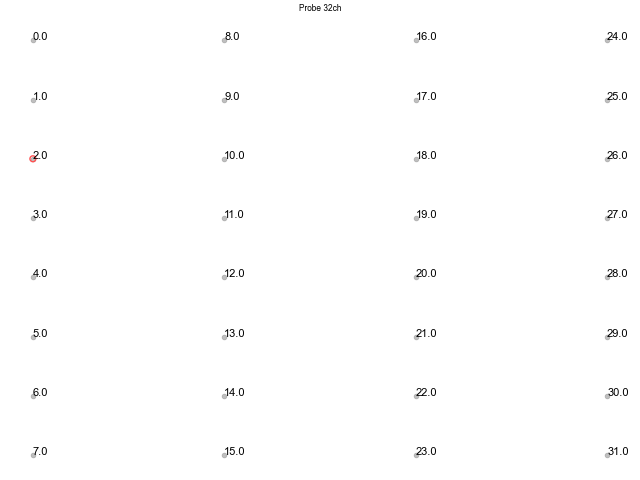

In [21]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=4, contacts_per_column=8, xpitch=125,
                   ypitch=-20, channel_id=np.arange(0, 32, 1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

In [22]:
art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
art_epochs = Epoch(epochs=None, file=art_epochs_file)

In [ ]:
# ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
# sess.recinfo.write_epochs(epochs=ripple_epochs, ext='swr')
# ripple_epochs.save(ripple_epochs_file)

### Plot example ripples

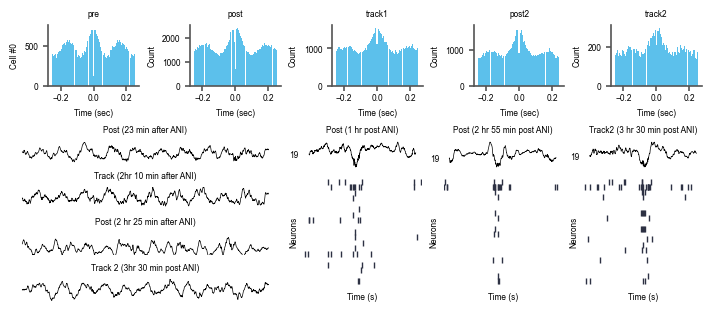

In [24]:
from neuropy.plotting.spikes import plot_raster
# Get Signals for various epochs to look for ripples
# swr_track = get_epoch_signal(saline2_signal, 'Track 1', saline2_epochs, channel_indx=[16])
# swr_post = get_epoch_signal(saline2_signal, 'Post', saline2_epochs, channel_indx=[16])
# swr_track2 = get_epoch_signal(saline2_signal, 'Track 2', saline2_epochs, channel_indx=[16])

ax_swr = FigS7.subplot2grid(FigS7.gs[1:, 2:], height_ratios=[1, 4], grid=(2, 3), return_axes=True)

# Plot Post 1 LFP and Spikes
t_start, t_stop = 85*60 + 12.2, 85*60 + 13.2
plot_signal_traces(ani_signal.time_slice(t_start=t_start, t_stop=t_stop, channel_id=19), ax=ax_swr[0, 0], lw=0.5)
plot_raster(sess.neurons.time_slice(t_start=t_start, t_stop=t_stop), ax=ax_swr[1,0], markersize=4)
sns.despine(ax=ax_swr[1,0], bottom=True, left=True)
ax_swr[1,0].set_xticks([])
ax_swr[1,0].set_yticks([])
ax_swr[0,0].set_title('Post (1 hr post ANI)')

# Plot Post 2
t_start, t_stop = 192*60 + 58.3, 192*60 + 59.3
plot_signal_traces(ani_signal.time_slice(t_start=t_start, t_stop=t_stop, channel_id=19), ax=ax_swr[0, 1], lw=0.5)
plot_raster(sess.neurons.time_slice(t_start=t_start, t_stop=t_stop), ax=ax_swr[1,1], markersize=4)
sns.despine(ax=ax_swr[1,1], bottom=True, left=True)
ax_swr[1,1].set_xticks([])
ax_swr[1,1].set_yticks([])
ax_swr[0,1].set_title('Post (2 hr 55 min post ANI)')

# Plot Track 2 LFP and Spikes
t_start, t_stop = 237*60 + 11.4, 237*60 + 12.4
plot_signal_traces(ani_signal.time_slice(t_start=t_start, t_stop=t_stop, channel_id=19), ax=ax_swr[0,2], lw=0.5)
plot_raster(sess.neurons.time_slice(t_start=t_start, t_stop=t_stop), ax=ax_swr[1,2], markersize=4)
sns.despine(ax=ax_swr[1,2], bottom=True, left=True)
ax_swr[1,2].set_xticks([])
ax_swr[1,2].set_yticks([])
ax_swr[0,2].set_title('Track2 (3 hr 30 min post ANI)')

FigS7.fig

In [25]:
FigS7.savefig(fig_save_dir / 'Figure S7_Rat2_ani.pdf')